In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import Levenshtein
import tqdm
from pandas.api import types
from pprint import pprint
from unicodedata import normalize
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn import metrics
import nltk
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV
import statsmodels
import scorecardpy
import joblib
from imblearn.over_sampling import SMOTE


# configurar opções
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)
pd.set_option('max_colwidth', 400)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
sns.set(style="darkgrid")
# stopwords em portugues
stop_pt = nltk.corpus.stopwords.words('portuguese')

# Desafio de Data Science do Creditas

Definição do problema:

> A Creditas precisa entender como podemos priorizar os clientes de maneira que os clientes que tenham a maior probabilidade de serem enviados para a análise de crédito sejam atendidos primeiro.

Portanto, temos uma variável resposta binária (enviar ou não um cliente para a análise de crédito) e um conjunto de variáveis de input. Deseja-se criar um modelo de Machine Learning com bom desempenho preditivo para a variável resposta.

O projeto está estruturado da seguinte maneira:  

1. Sumário executivo
2. Importação dos dados
3. EDA
4. Feature selection
5. Modelagem
6. Avaliação dos resultados dos modelos
7. Interpretabilidade do modelo
8. Conclusão e to-dos


# Sumário executivo

* 21,7% dos clientes do dataset que foram pré-aprovados são enviados para a fase de análise de crédito. Deseja-se criar um modelo que estime a probabilidade de isso acontecer.  
* Cada variável presente no dataset foi analisada individualmente com o objetivo de traçar a melhor estratégia de tratamento de dados ausentes e de feature engineering.  
* Foram usados dados externos de variáveis socioeconômicas que se mostraram relevantes para a modelagem da variável resposta.  
* Foi testado um método de rebalancing para lidar com o desbalanceamento das classes da variável resposta.  
* O melhor modelo, dentre os avaliados, foi o Xgboost, com um KS de 0,465.

# Importação dos dados

In [2]:
df = pd.read_csv('desafio-ds/dataset.csv')
# separar apenas os casos pre-aprovados
df = df[df['pre_approved'] == 1]
df.drop(columns = 'pre_approved', inplace = True)
print('Linhas e colunas do dataset: ', df.shape)

Linhas e colunas do dataset:  (35021, 32)


In [3]:
df.dtypes

id                        int64
age                     float64
monthly_income          float64
collateral_value        float64
loan_amount             float64
city                     object
state                    object
collateral_debt         float64
verified_restriction    float64
dishonored_checks         int64
expired_debts             int64
banking_debts             int64
commercial_debts          int64
protests                  int64
marital_status           object
informed_restriction    float64
loan_term               float64
monthly_payment         float64
informed_purpose         object
auto_brand               object
auto_model               object
auto_year               float64
pre_approved            float64
form_completed          float64
sent_to_analysis        float64
channel                  object
zip_code                 object
landing_page             object
landing_page_product     object
gender                   object
utm_term                 object
educatio

In [4]:
df.head(10)

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,expired_debts,banking_debts,commercial_debts,protests,marital_status,informed_restriction,loan_term,monthly_payment,informed_purpose,auto_brand,auto_model,auto_year,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
0,100001025857,61.00000,1300.00000,nan,10000.00000,NaN,NaN,nan,nan,0,0,0,0,0,NaN,nan,nan,nan,NaN,Ford,GOL,2010.00000,0.00000,1.00000,0.00000,NaN,5754XXXX,NaN,NaN,male,NaN,NaN
1,173466,50.00000,3500.00000,40000.00000,23936.00000,Muriaé,MG,nan,1.00000,0,0,1,0,0,NaN,1.00000,nan,813.00000,"pagar custos de escrituras de terreno , cartão de credito e cheque especial",GM - Chevrolet,SPIN LT 1.8 8V Econo.Flex 5p Mec.,2014.00000,0.00000,0.00000,0.00000,search,3688XXXX,/emprestimo/garantia-veiculo,AutoRefinancing,NaN,c,NaN
2,173465,31.00000,2600.00000,18000.00000,5000.00000,Araxá,MG,10000.00000,0.00000,0,0,0,0,0,NaN,1.00000,nan,208.33000,para pagar contas,GM - Chevrolet,Corsa Sed Class.Life 1.0/1.0 FlexPower,2008.00000,0.00000,1.00000,0.00000,display,3818XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN
3,173464,51.00000,3600.00000,21000.00000,10000.00000,Jaú,SP,8000.00000,1.00000,0,0,1,1,1,NaN,1.00000,nan,323.53000,quitar o carro,Fiat,Palio 1.0 ECONOMY Fire Flex 8V 4p,2012.00000,0.00000,0.00000,0.00000,0,1720XXXX,/emprestimos/garantia-veiculo/solicitar,NaN,male,NaN,NaN
4,173463,51.00000,1500.00000,10000.00000,8000.00000,Veranópolis,RS,0.00000,nan,0,0,0,0,0,NaN,1.00000,nan,333.33000,investimento,Fiat,Uno Mille EP 2p e 4p,1996.00000,0.00000,0.00000,0.00000,display,9533XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN
5,173462,25.00000,4000.00000,39000.00000,10000.00000,São Paulo,SP,33000.00000,0.00000,0,0,0,0,0,NaN,0.00000,nan,974.87000,Novo projeto,Kia Motors,Cerato 1.6 16V Aut.,2011.00000,0.00000,0.00000,0.00000,search,2834XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN
6,173461,63.00000,5100.00000,10500.00000,9450.00000,São Paulo,SP,0.00000,nan,0,0,0,0,0,NaN,1.00000,nan,305.74000,comprar carro,Kia Motors,Sportage Grand 2.0 16V Mec.,1999.00000,0.00000,0.00000,0.00000,display,5368XXXX,/emprestimos/garantia-veiculo/solicitar,NaN,male,NaN,NaN
7,173460,52.00000,5668.00000,24000.00000,5000.00000,São Paulo,SP,900.00000,0.00000,0,0,0,0,0,NaN,0.00000,nan,161.77000,cobrir cheque especial,Nissan,LIVINA 1.6 16V Flex Fuel 5p,2011.00000,1.00000,0.00000,0.00000,search,4028XXXX,/emprestimos/solicitar,PersonalLoan,female,NaN,"Ensino médio completo (antigo 2º grau, secundário ou colegial)."
8,173458,54.00000,3800.00000,8000.00000,5000.00000,CAMPOS DOS GOYT,RJ,0.00000,nan,0,0,0,0,0,NaN,0.00000,nan,208.33000,"Para investir em um novo negócio de frios e ampliar o meu negócio de distribuição de guaravita, refresco similar, no qual tenho exclusividade e doces.",Ford,Escort L/LX 1.6,1988.00000,0.00000,0.00000,0.00000,display,2801XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN
9,173457,25.00000,1200.00000,10000.00000,8000.00000,Rolândia,PR,2000.00000,nan,0,0,0,0,0,NaN,1.00000,nan,416.67000,Pra quitação do carro,Ford,Corcel II L,1986.00000,0.00000,0.00000,0.00000,display,8660XXXX,/emprestimos/solicitar,PersonalLoan,female,NaN,NaN


# EDA

A tabela abaixo contém a descrição de cada coluna presente no dataset.

In [6]:
description = pd.read_csv("desafio-ds/description.csv")
description.sort_values('id')

,id,Chave única de uma solicitação de cliente
0,age,Idade do cliente
18,auto_brand,Marca do carro
19,auto_model,Modelo do carro
20,auto_year,Ano do carro
10,banking_debts,Indica se o cliente possui divídas bancárias
24,channel,Canal de entrada do lead
4,city,Cidade do cliente
6,collateral_debt,Valor que o automovel do cliente tem de dívida (ex. Valor que ainda está financiado)
2,collateral_value,Valor do automóvel que será dado em garantia
11,commercial_debts,Indica se o cliente possui dividas comerciais


Como próximo passo, é analisada a ausência de dados (`Nan`) nas variáveis.

In [7]:
df.isna().mean().sort_values(ascending = False)

loan_term              1.00000
marital_status         0.97320
utm_term               0.68171
landing_page_product   0.38036
collateral_debt        0.35382
education_level        0.19248
gender                 0.12614
informed_restriction   0.05374
monthly_payment        0.05000
informed_purpose       0.03887
channel                0.03767
landing_page           0.03767
verified_restriction   0.00427
collateral_value       0.00087
city                   0.00053
auto_model             0.00007
form_completed         0.00000
dishonored_checks      0.00000
age                    0.00000
monthly_income         0.00000
loan_amount            0.00000
state                  0.00000
banking_debts          0.00000
expired_debts          0.00000
pre_approved           0.00000
commercial_debts       0.00000
protests               0.00000
zip_code               0.00000
sent_to_analysis       0.00000
auto_brand             0.00000
auto_year              0.00000
id                     0.00000
dtype: f

Algumas variáveis são totalmente vazias, como `loan_term` e `marital_status`. Isso pode ser explicado por essas variáveis serem preenchidas apenas em uma etapa seguinte do processo, caso o cliente seja aprovado para ser enviado para a análise de crédito. Assim, essas variáveis serão descartadas.

A variável `utm_term` possui 68% de ausência de dados. Como essa variável diz respeito ao tipo de dispositivo que o cliente acessou o site da Creditas, a ausência de dados pode significar que o cliente não acessou o site da Creditas, podendo ser uma aquisição de um meio não-digital, como telefone. Por isso, o valor ausente será substituído por um placeholder qualquer, como -1, que representa que não houve acesso. Essa mesma estratégia será adotada para variáveis como `education_level`, `landing_page_product` e `verified_restriction`, entre outras.

A ausência de valores na variável `collateral_debt` também deve ser interpretada de forma especial. Ela só existe caso o cliente tenha adquirido seu carro por financiamento. Caso contrário, essa variável não é definida.

Para as demais variáveis, como o porcentual de NAs é pequeno, vou optar por substituir pela mediana para variáveis numéricas e pela moda para variáveis categóricas, para não ocasionar a remoção desses clientes do dataset. A variável resposta, `sent_to_analysis`,  será renomeada para `y` por conveniência.

Antes de partir para a análise, o dataset será separado em treino e teste, para evitar que a análise exploratória e a modelagem não resultem em overfitting.




In [8]:
# filtrar fora casos NaN na variavel resposta
df = df[df['sent_to_analysis'].notnull()]
df = df.drop(columns = ['marital_status', 'loan_term'])

# renomear variável target
df = df.rename(columns  = {'sent_to_analysis' : 'y'})
# criar sets de treino e teste
tr = df.sample(frac = 0.70, random_state = 42)
te = df.drop(tr.index)

# remover coluna de id
tr = tr.drop(columns = 'id')
te = te.drop(columns = 'id')

Algo fundamental a se conhecer sobre o dataset é sobre a distribuição da variável resposta:

In [9]:
np.round(np.mean(tr['y']), 5)

0.21754

Isto é, apenas 22% dos casos são aprovados para a etapa seguinte no processo da Creditas. É um dataset com classes relativamente desbalanceadas.

A tabela abaixo mostra a distribuição em quartis das variáveis numéricas.

In [10]:
tr.describe(percentiles = [.10, .25, .50, .75, .90, .95]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,max
age,10499.00000,38.21288,11.59631,18.00000,25.00000,29.00000,36.00000,46.00000,55.00000,59.00000,115.00000
monthly_income,10499.00000,10252.95005,124923.00949,3.00000,1800.00000,2500.00000,4000.00000,6000.00000,10000.00000,13855.00000,6312000.00000
collateral_value,10493.00000,48811.17792,1108233.91921,0.00000,13000.00000,17000.00000,23000.00000,34000.00000,46000.00000,60000.00000,99999999.00000
loan_amount,10499.00000,14630.79811,12507.85275,2500.00000,5000.00000,6000.00000,10500.00000,18900.00000,28000.00000,35910.00000,250000.00000
collateral_debt,6785.00000,4845.95611,123417.73261,0.00000,0.00000,0.00000,0.00000,2000.00000,12000.00000,20000.00000,10100000.00000
verified_restriction,10463.00000,0.13877,0.34573,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000
dishonored_checks,10499.00000,0.01791,0.13262,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
expired_debts,10499.00000,0.00190,0.04361,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
banking_debts,10499.00000,0.05810,0.23395,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000
commercial_debts,10499.00000,0.08848,0.28401,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000


Alguns comentários sobre a tabela acima:  

* Apesar de ser meio incomum alguém ter 115 anos de idade, não há valores absurdos na variávei `age`.  
* Variáveis monetárias (`monthly_income`, `collateral_value`, `loan_amount`, `collateral_debt` e `monthly_payment`) possui valores extremos que devem ser tratados com cautela. É muito improvável, por exemplo, que alguém que tenha uma renda mensal informada de R\\$ 40.004.000 precise de um empréstimo.  Mesmo sabendo que muitas variáveis seguem uma distribuição binomial negativa, com valores extremos sendo comuns, tais valores precisam ser tratados antes de serem transformados para a escala logarítmica.  
* Algumas das variáveis numéricas são binárias, portanto devem ser tratadas como categóricas.
* O valor 99999999.00000 em `collateral_value` provavelmente representa um `NaN`.  
* Alguns carros estão marcados com ano (`auto_year`) zero. Isso é um problema de qualidade de dados que pode ser tratado o substituindo pela mediana (2009).

A forma escolhida para tratar valores positivos extremos foi os substituir pelo percentil 95% da variável. Todo esse processo de limpeza de dados será feito por meio de funções para padronizar o processo.


In [11]:
## tratamento de NAs
def tratar_NAs(dframe):
    dframe['utm_term'].fillna("missing",  inplace = True)
    dframe['education_level'].fillna("missing",  inplace = True)
    dframe['landing_page_product'].fillna("missing",  inplace = True)
    dframe['verified_restriction'].fillna(-1,  inplace = True)
    
    dframe['has_collateral_debt'] = np.where(dframe['collateral_debt'].isnull(), 0, 1)
    dframe['auto_year'] = np.where(dframe['auto_year'] == 0, np.nan, dframe['auto_year'])
    
    return(dframe)



def tratar_variaveis_monetarias(dframe):
    # para as variaveis monetarias, substituuir valores extremos positivos pelo percentil 95%
    # e converter para log
    cols = ['monthly_income', 'collateral_value', 'loan_amount',
            'collateral_debt', 'monthly_payment']
    
    for c in cols:
        p = np.percentile(dframe[c], 95)
        dframe[c] = np.log1p(np.where(dframe[c] >= p, p, dframe[c]))

    return(dframe)

def tratar_education_level(dframe):
    dframe['education_level'].replace('Analfabeto, inclusive o que, embora tenha recebido instrução, não se alfabetizou.', 'A-Analfabeto', inplace = True)
    dframe['education_level'].replace('Até a 4ª série incompleta do ensino fundamental (antigo 1º grau ou primário), que se tenha alfabetizado sem ter freqüentado escola regular.', 'B-Ate 4a serie', inplace = True)
    dframe['education_level'].replace('4ª série completa do ensino fundamental (antigo 1º grau ou primário).', 'C-4a serie completa', inplace = True)
    dframe['education_level'].replace('Da 5ª à 8ª série do ensino fundamental (antigo 1º grau ou ginásio).', 'D-Ate 8a serie', inplace = True)
    dframe['education_level'].replace('Ensino fundamental completo (antigo 1º grau ou primário e ginasial).', 'E-fundamental incompleto', inplace = True)
    dframe['education_level'].replace('Ensino médio incompleto (antigo 2º grau, secundário ou colegial).', 'F-Ensino medio incompleto', inplace = True)
    dframe['education_level'].replace('Ensino médio completo (antigo 2º grau, secundário ou colegial).', 'G-Ensino medio completo', inplace = True)
    dframe['education_level'].replace('Educação superior incompleta.', 'H-Ensino superior incompleto', inplace = True)
    dframe['education_level'].replace('Educação superior completa', 'I-Ensino superior completo', inplace = True)
    
    return(dframe)
    
def tratar_dados_creditas(dframe):
    dframe = tratar_NAs(dframe)
    dframe = tratar_variaveis_monetarias(dframe)
    dframe = tratar_education_level(dframe)
    
    return(dframe)
    

In [12]:

tr = tratar_dados_creditas(tr)
te = tratar_dados_creditas(te)

In [13]:
# substituir NAs por media do treino
medianas_treino = tr.median()
tr = tr.fillna(medianas_treino)
te = te.fillna(medianas_treino)

# nas colunas categorias, substituir NA por moda
modas_treino = tr.mode(axis = 'index', dropna = True)

for col in modas_treino.columns:
    tr[col].fillna(modas_treino[col].iloc[0], inplace = True)
    te[col].fillna(modas_treino[col].iloc[0], inplace = True)


## Multicolinearidade

Um aspecto importante a ser analisado é a presença de multicolinearidade entre as variáveis de input, que é reduz a performance dos modelos ajustados.

In [14]:
def correl_df(dframe):
    correl_matrix = dframe.corr()
    # Select upper triangle of correlation matrix
    upper = correl_matrix.where(np.triu(np.ones(correl_matrix.shape), k=1).astype(np.bool)).head()
    upper = upper.unstack().reset_index()
    # rename columns
    upper.columns = ['var1', 'var2', 'correl']
    # drop na
    upper = upper.dropna()
    upper['correl_abs'] = np.abs(upper['correl'])
    return(upper.sort_values(by = 'correl_abs', ascending = False))

correl_df(tr).head(10)

,var1,var2,correl,correl_abs
63,monthly_payment,loan_amount,0.76814,0.76814
61,monthly_payment,monthly_income,0.53594,0.53594
16,loan_amount,monthly_income,0.51380,0.51380
62,monthly_payment,collateral_value,0.43572,0.43572
67,auto_year,collateral_value,0.42765,0.42765
17,loan_amount,collateral_value,0.42584,0.42584
11,collateral_value,monthly_income,0.40844,0.40844
89,has_collateral_debt,collateral_debt,0.39807,0.39807
84,y,collateral_debt,-0.21241,0.21241
5,monthly_income,age,0.21201,0.21201


A tabela acima mostra que o maior valor de correlação absoluta entre um par de variáveis é de 0,76, o que não chega a ser um caso de multicolinearidade.

## Visualização de dados e Feature Engineering

Nesta seção, serão apresentados gráficos sobre a variável resposta em função de cada variável de input presente no dataset.

### Idade

Dado que idade é uma variável numérica, uma boa forma de a representar visualmente como é por meio de um boxplot.

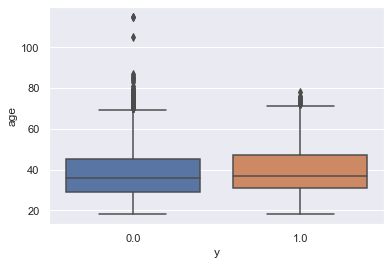

In [15]:
sns.boxplot(data = tr, x = 'y', y = 'age')
plt.show()

Aparentemente, não há distinção da distribuição da idade em função da variável resposta.

Como a idade também pode ser interpretada como uma variável discreta, visto que ela é da classe inteira, pode-se calcular a taxa média de clientes enviados para a análise de crédito por idade.

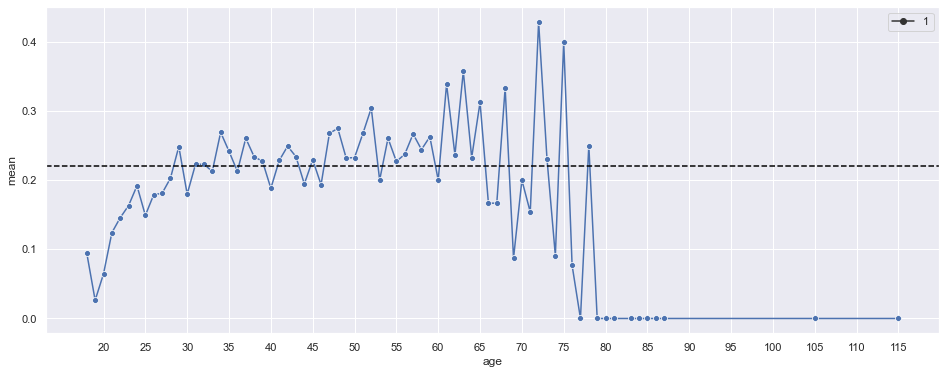

In [16]:
tr_por_idade = tr.groupby('age')['y'].agg(['mean', 'size']).reset_index()
tr_por_idade['age'] = tr_por_idade['age'].astype(int)

plt.figure(figsize=(16, 6))
sns.lineplot(data = tr_por_idade, x = 'age', y = 'mean', style = 1, markers = True)
plt.axhline(.22, color = 'black', linestyle = 'dashed')
plt.xticks(np.arange(20, 120, 5))
plt.show()

A relação mostrada no gráfico é interessante. A taxa da variável resposta é baixa para clientes mais jovens (até 25 anos), apresenta seu maior resultado de 60 a 70 anos mas volta a cair a partir dos 80 anos. Dificilmente um modelo linear, como regressão logística, conseguirá extrair essa relação, mas um modelo de árvore, como Random Forest, pode funcionar bem.

### Identificações do carro

Existem três variáveis de input que retratam características  do carro que está sendo oferecido como garantia do empréstimo: `auto_brand`, `auto_model` e `auto_value`.

Para automatizar o processo de análise da variável resposta em função das variáveis categóricas presentes no dataset, foi criada a função `analisar_variavel_categorica()` com o código abaixo:

In [17]:
def analisar_variavel_categorica(nome_var):
    out = tr.groupby(nome_var)['y'].agg(['mean', 'size']).reset_index()
    out = out.sort_values('size', ascending = False)
    out['size_pct'] = out['size']/len(tr)
    out['size_pct_cum'] = np.cumsum(out['size_pct'])
    
    return(out)

In [18]:
_ = analisar_variavel_categorica('auto_brand').head(10)
_

,auto_brand,mean,size,size_pct,size_pct_cum
16,Fiat,0.19008,2157,0.20545,0.20545
18,GM - Chevrolet,0.21778,2025,0.19288,0.39832
44,VW - VolksWagen,0.22133,1744,0.16611,0.56443
17,Ford,0.20708,1159,0.11039,0.67483
37,Renault,0.25220,682,0.06496,0.73978
20,Honda,0.14307,678,0.06458,0.80436
35,Peugeot,0.24829,439,0.04181,0.84618
21,Hyundai,0.24722,360,0.03429,0.88046
11,Citroën,0.27761,335,0.03191,0.91237
43,Toyota,0.26761,213,0.02029,0.93266


Plotando os  resultados em um gráfico:

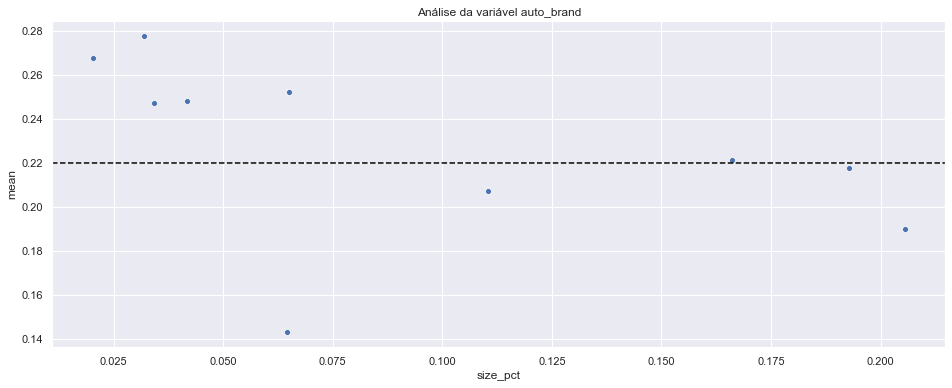

In [19]:

plt.figure(figsize=(16, 6))
sns.scatterplot(data = _, x = 'size_pct', y = 'mean')
plt.axhline(.22, color = 'black', linestyle = 'dashed')
plt.title('Análise da variável auto_brand')
plt.show()

Essa variável não aparenta ser importante. Como era esperado, as 4 principais marcas de carro correspondem a cerca de 70% de todos os carros, sendo que não tem uma taxa de aceitação muito diferente da média geral do dataset de treino.

Algumas marcas se destacam positivamente, obtendo taxas de aceitação próximas a 30%, mas possuem poucas observações no dataset. Os dois fatos podem ser explicados por essas marcas não terem carros de entrada de valor baixo, ou seja, qualquer carro dessas marcas terá um preço bem maior que o de um carro popular. Ou seja, existe uma variável latente que é o preço do carro que explica esse resultado das marcas de carro mais caras.

Sobre `auto_model`: 

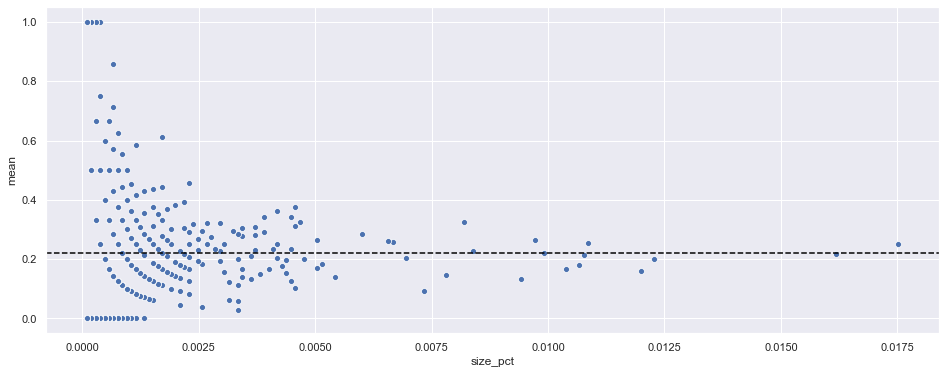

In [20]:
_ = analisar_variavel_categorica('auto_model')

plt.figure(figsize=(16, 6))
sns.scatterplot(data = _, x = 'size_pct', y = 'mean')
plt.axhline(.22, color = 'black', linestyle = 'dashed')
plt.show()

A variável de modelo do carro também não discrimina a variável resposta. Isto é, não há nenhum modelo de carro, dentre os mais representativos do dataset, que tenha uma taxa de aceitação muito maior ou menor que a geral.

Sobre `auto_year`:

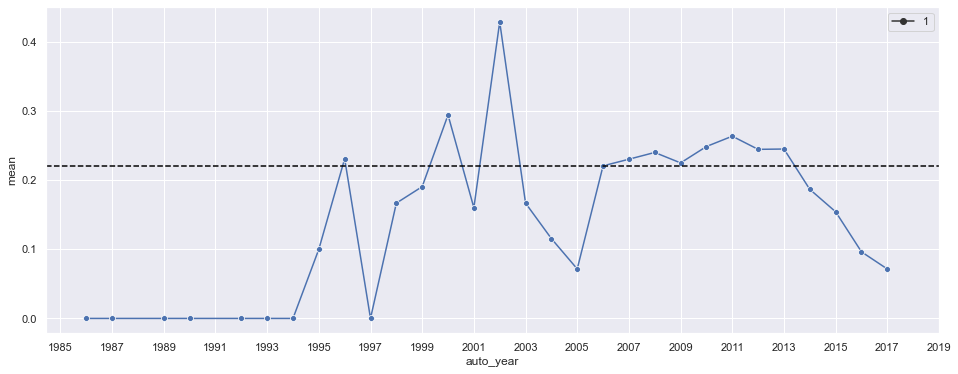

In [21]:
tr_por_ano = tr.groupby('auto_year')['y'].agg(['mean', 'size']).reset_index()
tr_por_ano['auto_year'] = tr_por_ano['auto_year'].astype(int)

plt.figure(figsize=(16, 6))
sns.lineplot(data = tr_por_ano, x = 'auto_year', y = 'mean', style = 1, markers = True)
plt.axhline(.22, color = 'black', linestyle = 'dashed')
plt.xticks(np.arange(1985, 2020, 2))
plt.show()

As observações que podem ser feitas sobre o gráfico são semelhantes às do gráfico de idade: a relação existe, mas não é linear. 

A tabela mostra que clientes que possuem dívidas bancárias raramente são aceitos, apesar de representarem 16% de toda a base. É uma variável super relevante.

### channel

In [22]:
_ = analisar_variavel_categorica('channel')
_

,channel,mean,size,size_pct,size_pct_cum
6,search,0.24455,4539,0.43233,0.43233
2,display,0.11974,1545,0.14716,0.57948
0,affiliates,0.24446,1129,0.10753,0.68702
5,remarketing,0.16849,914,0.08706,0.77407
7,seo,0.26918,769,0.07325,0.84732
3,emailaffiliates,0.07847,548,0.05220,0.89951
1,direct,0.30798,526,0.05010,0.94961
4,referral,0.28856,402,0.03829,0.98790
8,social,0.24409,127,0.01210,1.00000


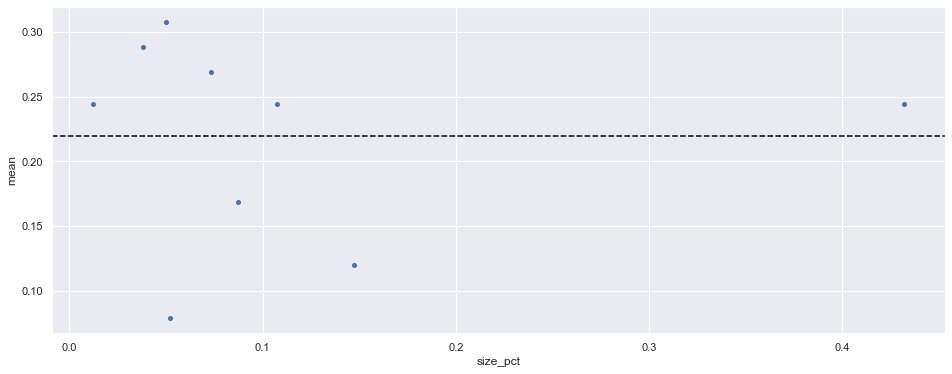

In [23]:

plt.figure(figsize=(16, 6))
sns.scatterplot(data = _, x = 'size_pct', y = 'mean')
plt.axhline(.22, color = 'black', linestyle = 'dashed')
plt.show()

A tabela e o gráfico acima mostram qie o canal `display` se destaca negativamente, apesar de ser o segundo mais popular no dataseyt. É um indício de relevância para a variável.

Contudo, existem alguns canais que são pouco representativos para a amostra. Estes serão convertidos para a label *Outros*.

In [24]:
# remover canais menos usados
tr['channel'] = np.where(tr['channel'].isin(['referral', 'social', '0']), 'Outros', tr['channel'])
te['channel'] = np.where(te['channel'].isin(['referral', 'social', '0']), 'Outros', te['channel'])

### city e state

A tabela abaixo mostra o índice da variável resposta por estado.

In [25]:
analisar_variavel_categorica('state')

,state,mean,size,size_pct,size_pct_cum
25,SP,0.23713,4369,0.41613,0.41613
18,RJ,0.22824,942,0.08972,0.50586
10,MG,0.22598,916,0.08725,0.59310
17,PR,0.22719,559,0.05324,0.64635
23,SC,0.15202,421,0.04010,0.68645
6,DF,0.21311,366,0.03486,0.72131
22,RS,0.24286,350,0.03334,0.75464
4,BA,0.18076,343,0.03267,0.78731
8,GO,0.21429,336,0.03200,0.81932
5,CE,0.18750,256,0.02438,0.84370


Alguns estados apresentam resultados destoantes da baseline de 9%. Contudo, estes são pouco representativos no dataset, o que implica que os resultados podem ser devido à alta variabilidade decorrente da baixa amostragem.

No gráfico abaixo, vemos os resultados por município.

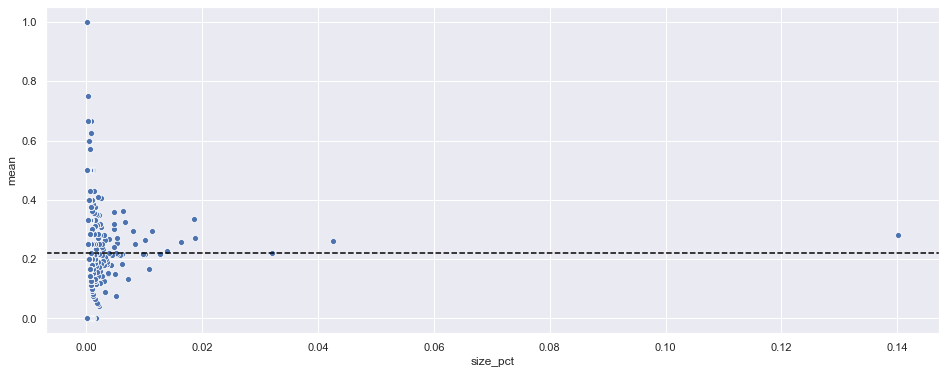

In [26]:
tr_por_municipio = analisar_variavel_categorica(['city', 'state'])

plt.figure(figsize=(16, 6))
sns.scatterplot(data = tr_por_municipio, x = 'size_pct', y = 'mean')
plt.axhline(.22, color = 'black', linestyle = 'dashed')
plt.show()

É difícil notar algum padrão nos dados acima. São milhares de cidades, a maioria sendo pouco representada no dataset. Vejamos os resultados em tabela:

In [27]:
tr_por_municipio.sort_values('size', ascending = False)

,city,state,mean,size,size_pct,size_pct_cum
1549,São Paulo,SP,0.28057,1472,0.14020,0.14020
1315,Rio de Janeiro,RJ,0.26116,448,0.04267,0.18287
228,Brasília,DF,0.22024,336,0.03200,0.21488
463,Curitiba,PR,0.27273,198,0.01886,0.23374
182,Belo Horizonte,MG,0.33673,196,0.01867,0.25240
...,...,...,...,...,...,...
1819,rio de jjaneiro,RJ,0.00000,1,0.00010,0.93114
10,Abaeté,MG,0.00000,1,0.00010,0.93123
1816,rio claro,SP,0.00000,1,0.00010,0.93133
1815,ribeirao das neves MG,MG,0.00000,1,0.00010,0.93142


Os resultados por cidade são decepcionantes. Como existe uma certa desigualdade geográfica de renda no Brasil, com algumas cidades sendo muito mais ricas que a maioria, era de se esperar que essa variável aparecesse como relevante. Contudo, a quantidade muito grande de diferentes valores (3396 cidades diferentes) torna difícil chegar nessa conclusão. Por isso, foi realizado um processo de **feature engineering** para coletar indicadores socioeconômicos para os municípios brasileiros com o objetivo de adicionar essas variáveis ao nosso dataset.

Utilizei como fonte dois datasets públicos:  
* [Atlas do desenvolvimento humano](http://atlasbrasil.org.br/2013/)  
* [PIB dos municípios (IBGE)](https://www.ibge.gov.br/estatisticas/economicas/contas-nacionais/9088-produto-interno-bruto-dos-municipios.html?=&t=downloads)  

Os indicadores socioeconômicos coletados são:

* PIB per capita  
* População  
* Índice de desenvolvimento humano municipal (IDHM)


O processo de junção dos dois arquivos e criação do arquivo resumido `dados_resumidos.csv` está descrito no script auxiliar `dados_municipios_ibge.py` neste repositório.



In [28]:
df_ibge = pd.read_csv('dados_municipios_ibge.csv')
df_ibge.head()

,codigo_municipio,nome_municipio,sigla_uf,pib_per_capita,populacao_total,idhm
0,1100015,Alta Floresta D'Oeste,RO,19611.75000,24392.00000,0.64100
1,1100023,Ariquemes,RO,21389.67000,90353.00000,0.70200
2,1100031,Cabixi,RO,22315.80000,6313.00000,0.65000
3,1100049,Cacoal,RO,24037.91000,78574.00000,0.71800
4,1100056,Cerejeiras,RO,25009.71000,17029.00000,0.69200


In [29]:
# verificando se existe multicolinearidade nas variaveis dos datasets publicos
df_ibge[['pib_per_capita', 'populacao_total', 'idhm']].corr()

,pib_per_capita,populacao_total,idhm
pib_per_capita,1.00000,0.07667,0.49052
populacao_total,0.07667,1.00000,0.13896
idhm,0.49052,0.13896,1.00000


Contudo, há um outro problema. Como está explícito nas últimas linhas da tabela de municípios da base da Creditas, alguns valores do campo `city` estão com erros de grafia (*rio de jjaneiro*, por exemplo) o que impossibilita, nesses casos, juntar a base da Creditas com a do IBGE. Para evitar perda de dados, implementei um processo de **string similarity** para aumentar a quantidade de matches de nomes de cidades das duas bases.

O processo foi implementado seguindo este algoritmo:

1. Um dicionário é criado, onde as chaves são os estados (as siglas) e seus valores são os municípios presentes no dataset.  
2. Os nomes das cidades no dataset passam pela função `limpar_nome_cidade()` que os padroniza.  
3. Para cada UF presente no dicionário criado em 1., é executado um novo loop para cada cidade, comparando seu nome aos nomes de cidades do dataset do IBGE do mesmo estado (isso é feito para evitar homônimos). Tal comparação é feita usando o algoritmo **Levenshtein ratio similarity** , que calcula a similaridade entre um par de strings entre 0 a 1. Gerado o vetor de similaridade da cidade Creditas com as cidades do IBGE, é selecionada aquela que possui o maior valor. 
4. O resultado é salvo um dicionário.  


In [30]:
# coletar valores unicos de cidades no dataset da creditas
dict_creditas_cidades = df[['state', 'city']].dropna().drop_duplicates()
# transformar para dict
dict_creditas_cidades = dict_creditas_cidades.groupby('state')['city'].apply(lambda x: list(np.unique(x)))
dict_creditas_cidades = dict_creditas_cidades.to_dict()
# printar exemplo
dict_creditas_cidades['AC']

['Acrelândia',
 'Cruzeiro do Sul',
 'Epitaciolândia',
 'Plácido de Castro',
 'RIO BRANCO',
 'Rio Branco',
 'São Paulo',
 'Tarauacá',
 'cruzeiro do Sul']

In [31]:
def limpar_nome_cidade(txt):
    # converter para minusculo
    txt = txt.lower()
    # remover acentos
    txt = normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')
    
    return(txt)

# teste
limpar_nome_cidade("SÃO PAULO")

'sao paulo'

In [32]:
# inicializar dicionario para armazenar os objetos do loop
dict_uf = {}

for uf, lst_cidades_creditas in dict_creditas_cidades.items():
    # filtrar cidades do mesmo uf no dataset do ibge
    df_ibge_uf = df_ibge[df_ibge['sigla_uf'] == uf]
    nm_mun_ibge = list(df_ibge_uf['nome_municipio'])
    nm_cod_ibge = list(df_ibge_uf['codigo_municipio'])
    # calcular similaridade entre cada cidade do dataset da creditas e cada cidade no dataset do ibge
    lst_dicts_cidades = []
    for c in lst_cidades_creditas:
        lst_simil_values = [Levenshtein.ratio(limpar_nome_cidade(c), limpar_nome_cidade(m)) for m in nm_mun_ibge]
        maior_simil_valor = np.max(lst_simil_values)
        maior_simil_nome_cidade = nm_mun_ibge[np.argmax(lst_simil_values)]
        maior_simil_cod_cidade = nm_cod_ibge[np.argmax(lst_simil_values)]
        # salvar resultado em dicionario
        #dict_cidade_loop = {}
        dict_cidade_loop = {'cidade_creditas': c,
                               'valor_similaridade': maior_simil_valor,
                               'nome_cidade_ibge': maior_simil_nome_cidade,
                               'cod_cidade_ibge': maior_simil_cod_cidade}
        lst_dicts_cidades.append(dict_cidade_loop)
        
    dict_uf[uf] = lst_dicts_cidades

        

In [33]:
# Demonstração
dict_uf['AM'][:3]

[{'cidade_creditas': 'Humaitá',
  'valor_similaridade': 1.0,
  'nome_cidade_ibge': 'Humaitá',
  'cod_cidade_ibge': 1301704},
 {'cidade_creditas': 'Itacoatiara',
  'valor_similaridade': 1.0,
  'nome_cidade_ibge': 'Itacoatiara',
  'cod_cidade_ibge': 1301902},
 {'cidade_creditas': 'MANAUS',
  'valor_similaridade': 1.0,
  'nome_cidade_ibge': 'Manaus',
  'cod_cidade_ibge': 1302603}]

In [34]:
pd.DataFrame.from_dict(dict_uf['AM']).head(3)

,cidade_creditas,valor_similaridade,nome_cidade_ibge,cod_cidade_ibge
0,Humaitá,1.00000,Humaitá,1301704
1,Itacoatiara,1.00000,Itacoatiara,1301902
2,MANAUS,1.00000,Manaus,1302603


In [35]:
# transformar resultados em dataframe
df_cidades_match = [pd.DataFrame.from_dict(dict_uf[key]) for key in dict_uf.keys()]

df_cidades_match = pd.concat(df_cidades_match)
df_cidades_match = df_cidades_match.sort_values('valor_similaridade', ascending = False)

In [36]:
df_cidades_match.head()

,cidade_creditas,valor_similaridade,nome_cidade_ibge,cod_cidade_ibge
0,Acrelândia,1.00000,Acrelândia,1200013
31,Cruz Alta,1.00000,Cruz Alta,4306106
46,Giruá,1.00000,Giruá,4309001
45,Garibaldi,1.00000,Garibaldi,4308607
44,Feliz,1.00000,Feliz,4308102


In [37]:
df_cidades_match.tail()

,cidade_creditas,valor_similaridade,nome_cidade_ibge,cod_cidade_ibge
14,Taguatinga,0.33333,Brasília,5300108
13,TAGUATINGA,0.33333,Brasília,5300108
18,taguatinga df,0.28571,Brasília,5300108
10,Santa Maria DF.,0.26087,Brasília,5300108
2,05842-070,0.11111,Arco-Íris,3503356


Os resultados acima mostram que o ratio similarity funciona de forma apropriada. Contudo, chega-se a uma pergunta: qual o valor mínimo de similaridade que devemos usar para definir que dois pares de string são similares? Vejamos a distribuição dos reultados:

In [38]:
df_cidades_match['valor_similaridade'].describe(percentiles = [0, .02, .04, .06, .08, .1, 1])

count   2251.00000
mean       0.97922
std        0.08783
min        0.11111
0%         0.11111
2%         0.62500
4%         0.78261
6%         0.92308
8%         0.96000
10%        1.00000
50%        1.00000
100%       1.00000
max        1.00000
Name: valor_similaridade, dtype: float64

4% dos pares possuem similaridade de pelo menos .78, mas será que esse threshold é suficiente? Vejamos alguns casos:

In [39]:
df_cidades_match[df_cidades_match['valor_similaridade'] < .81].head(20)

,cidade_creditas,valor_similaridade,nome_cidade_ibge,cod_cidade_ibge
17,Palmas To,0.80000,Palmas,1721000
391,São Francisco Xavier,0.78788,São Francisco,3549003
61,Novo Gama - GO,0.78261,Novo Gama,5215231
63,Ouroana,0.76923,Uruana,5221700
59,Bonfim Paulista,0.75862,União Paulista,3555703
55,Morrinhos goias,0.75000,Morrinhos,5213806
58,Londrina,0.75000,Glorinha,4309050
89,Valparaiso I,0.75000,Valparaíso de Goiás,5221858
48,Guarajuba,0.75000,Irajuba,2914208
98,São José do Turvo,0.75000,São José de Ubá,3305133


Analisando os resultados acima empiricamente, pode-se chegar a conclusão de que 0.78 é um threshold aceitável, pois os pares abaixo disso provavelmente não representam a mesma cidade.

In [40]:
# considerar 0.78 como threshold
df_cidades_clean_match = df_cidades_match[df_cidades_match['valor_similaridade'] >= .78]

df_cidades_clean_match = df_cidades_clean_match.merge(df_ibge, how = 'inner', left_on = 'cod_cidade_ibge', right_on = 'codigo_municipio')

df_cidades_clean_match = df_cidades_clean_match[['cidade_creditas', 'sigla_uf', 'pib_per_capita', 'populacao_total', 'idhm']]

# converter variaveis de pib e população para a escala log
df_cidades_clean_match['pib_per_capita'] = np.log(df_cidades_clean_match['pib_per_capita'])
df_cidades_clean_match['populacao_total'] = np.log(df_cidades_clean_match['populacao_total'])

df_cidades_clean_match.columns = ['city', 'state', 'pib_per_capita', 'populacao_total', 'idhm']
df_cidades_clean_match.head()

,city,state,pib_per_capita,populacao_total,idhm
0,Acrelândia,AC,9.67935,9.43652,0.60400
1,Cruz Alta,RS,10.82473,11.04804,0.75000
2,cRUZ ALTA,RS,10.82473,11.04804,0.75000
3,Giruá,RS,10.52717,9.74537,0.72100
4,Garibaldi,RS,10.89511,10.33166,0.78600


Adicionando as variáveis criadas (`pib_per_capita`, `populacao_total` e `idhm`) ao dataset da Creditas:

In [41]:
tr = tr.merge(df_cidades_clean_match, how = 'inner', on = ['city', 'state'])
te = te.merge(df_cidades_clean_match, how = 'inner', on = ['city', 'state'])

Partimos então para analisar se as novas variáveis criadas ajudam a discriminar a variável resposta.

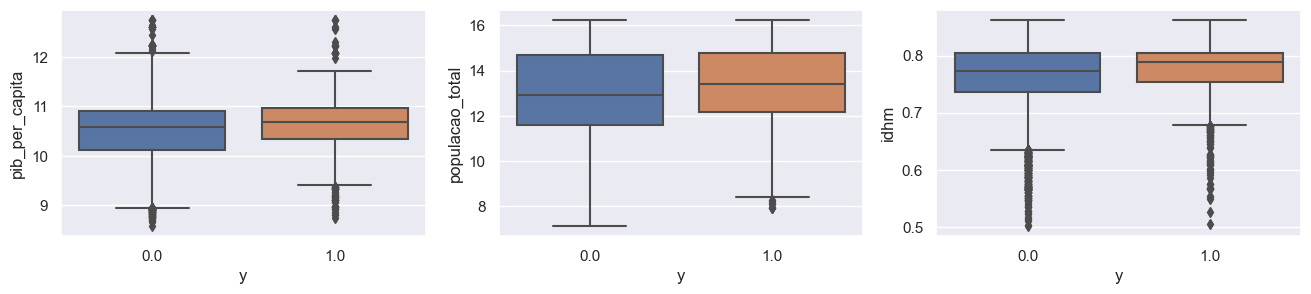

In [42]:
cols = ['pib_per_capita', 'populacao_total', 'idhm']


fig, axes = plt.subplots(1,3,figsize=(16,3), dpi= 100)

for idx, c in enumerate(cols):
    sns.boxplot(data = tr, x = 'y', y = c, ax = axes[idx])
plt.show()

Os gráficos mostram que as variáveis coletadas aparentam ser relevantes. Por exemplo, quanto maior o PIB per capita do município informado pelo cliente, maior a taxa de aceitação.

### has_collateral_debt, collateral_value e loan_amount

In [43]:
analisar_variavel_categorica('has_collateral_debt')

,has_collateral_debt,mean,size,size_pct,size_pct_cum
1,1,0.19465,6725,0.64577,0.64577
0,0,0.25942,3689,0.35423,1.00000


Dos clientes que não possuem valor financiado a ser pago no carro dado como garantia pelo empréstino, a taxa de aceitação é de 25,9%.

Vejamos o caso das variáveis `collateral_value` e `loan_amount`. Como são variáveis numéricas, uma boa forma de estudar a relação entre ambas e a variável resposta é por meio de um gráfico de dispersão.

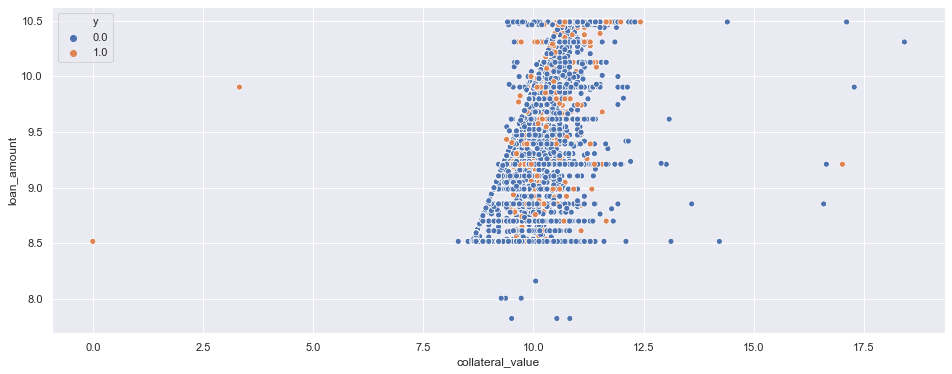

In [44]:
# collateral_value vs loan_amount
plt.figure(figsize=(16, 6))
sns.scatterplot(data = tr, x = 'collateral_value', y = 'loan_amount', hue = 'y')
plt.show()

Algumas observações sobre o gráfico acima:  
* Mesmo após a transformação das variáveis para a escala log, aida existem alguns valores extremos (collateral_value <= 7.5 e loan_amount <= 8.5), o que indica que ainda é necessário fazer algum tipo de tratamento e limpeza de dados nessas variáveis.  
* Os casos `1` da variável resposta parecem estar mais localizados no quadrante superior do gráfico, ou seja, solicitações de empréstimos com maiores valores dessas duas variáveis tendem a ser mais aceitos.

Um novo caso de feature engineering é testado, criando a variável `taxa_carro_emprestimo`, que calcula o valor que o o carro oferecido representa em relação ao valor solicitado de empréstimo.

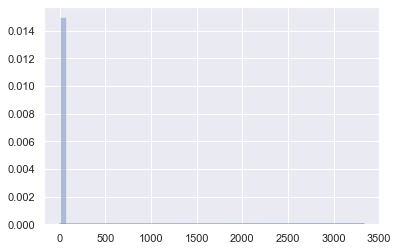

In [45]:
# o quanto que o valor do carro corresponde ao valor solicitado de emprestimo
taxa_carro_sobre_emprestimo = np.expm1(tr['collateral_value'])/np.expm1(tr['loan_amount'])
# plotando distribuicao da variavel
sns.distplot(taxa_carro_sobre_emprestimo)
plt.show()

Devido aos problemas de outliers mencionados acima, essa nova variável também possui valores extremos. Por isso, ela será representada em intervalos categóricos:

In [46]:
def criar_variavel_taxa_sobre_emprestimo(dframe):
    taxa_num = np.expm1(dframe['collateral_value'])/np.expm1(dframe['loan_amount'])
    # capar valor maximo
    taxa_num = np.where(taxa_num <= 3, taxa_num, 999)
    
    taxa_bins = pd.cut(taxa_num, bins = [0, 1, 2, 3, 999], include_lowest = True, labels = ['A', 'B', 'C', 'D'])
    dframe['taxa_valor_carro_sobre_emprestimo'] = taxa_bins
    
    return(dframe)

tr = criar_variavel_taxa_sobre_emprestimo(tr)
te = criar_variavel_taxa_sobre_emprestimo(te)

analisar_variavel_categorica('taxa_valor_carro_sobre_emprestimo')

,taxa_valor_carro_sobre_emprestimo,mean,size,size_pct,size_pct_cum
1,B,0.25565,5535,0.53150,0.53150
3,D,0.15535,2916,0.28001,0.81150
2,C,0.20159,1890,0.18149,0.99299
0,A,0.23288,73,0.00701,1.00000


Casos marcados como "A", que são aqueles em que o valor do carro é menor que o valor solicitado (`collateral_value/loan_amount <= 1`), possuem a maior taxa de aceitação (12,9%).

### monthly_income e monthly_payment

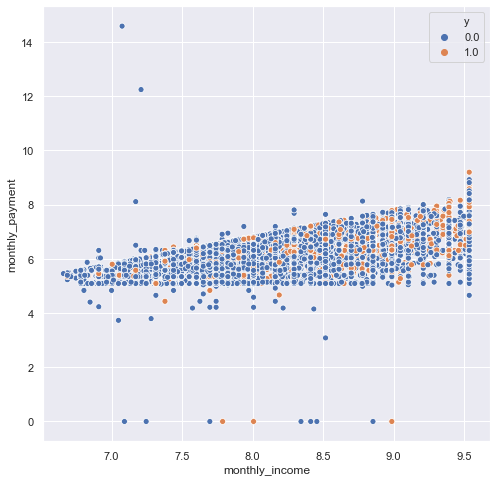

In [47]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data = tr[tr['monthly_income'] > 6], x = 'monthly_income', y = 'monthly_payment', hue = 'y')
plt.show()

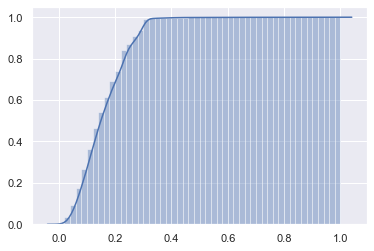

In [48]:
# pagamento por renda
taxa_pagamento_sobre_renda = (1 + np.expm1(tr['monthly_payment']))/(1 + np.expm1(tr['monthly_income']))
# corrigir valores extremos
taxa_pagamento_sobre_renda = np.where(taxa_pagamento_sobre_renda >= 1, 1, taxa_pagamento_sobre_renda)
taxa_pagamento_sobre_renda = np.where(taxa_pagamento_sobre_renda <= 0, 0, taxa_pagamento_sobre_renda)
tr['taxa_pagamento_sobre_renda_bins'] = pd.cut(taxa_pagamento_sobre_renda, 
                                               bins = np.arange(0, 1.1, .1),
                                               include_lowest = True)



kwargs = {'cumulative': True}
sns.distplot(taxa_pagamento_sobre_renda, hist_kws=kwargs, kde_kws=kwargs)
plt.show()

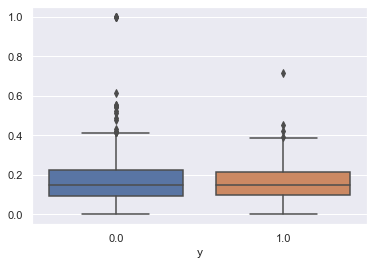

In [49]:
sns.boxplot(data = tr, x = 'y', y = taxa_pagamento_sobre_renda)
plt.show()

In [50]:
analisar_variavel_categorica('taxa_pagamento_sobre_renda_bins').sort_values('taxa_pagamento_sobre_renda_bins')

,taxa_pagamento_sobre_renda_bins,mean,size,size_pct,size_pct_cum
0,"(-0.001, 0.1]",0.20730,2769,0.26589,0.68946
1,"(0.1, 0.2]",0.23555,4411,0.42356,0.42356
2,"(0.2, 0.3]",0.21338,2601,0.24976,0.93922
3,"(0.3, 0.4]",0.15702,605,0.05809,0.99731
4,"(0.4, 0.5]",0.13333,15,0.00144,0.99875
5,"(0.5, 0.6]",0.00000,6,0.00058,0.99933
6,"(0.6, 0.7]",0.00000,1,0.00010,0.99990
7,"(0.7, 0.8]",1.00000,1,0.00010,1.00000
8,"(0.8, 0.9]",nan,0,0.00000,1.00000
9,"(0.9, 1.0]",0.00000,5,0.00048,0.99981


In [51]:
tr.drop(columns = 'taxa_pagamento_sobre_renda_bins', inplace = True)


### education_level

In [52]:
analisar_variavel_categorica('education_level')

,education_level,mean,size,size_pct,size_pct_cum
6,G-Ensino medio completo,0.19617,3864,0.37104,0.37104
9,missing,0.21645,2042,0.19608,0.56712
8,I-Ensino superior completo,0.31584,1982,0.19032,0.75744
4,E-fundamental incompleto,0.14191,754,0.07240,0.82984
7,H-Ensino superior incompleto,0.26558,674,0.06472,0.89457
5,F-Ensino medio incompleto,0.15015,646,0.06203,0.95660
3,D-Ate 8a serie,0.13603,272,0.02612,0.98272
2,C-4a serie completa,0.12037,108,0.01037,0.99309
1,B-Ate 4a serie,0.11111,63,0.00605,0.99914
0,A-Analfabeto,0.00000,9,0.00086,1.00000


Como era esperado, clientes com maior escolaridade possuem a maior taxa de aceitação.

Como os casos A (Analfabeto) a F (Ensino médio incompleto) são pouco representativos no dataset, estes serão substituídos pela label "Outros".

In [53]:
# refatorar variavel de educacao
manter = ['G-Ensino medio completo', 'H-Ensino superior incompleto', 'I-Ensino superior completo']

tr['education_level'] = np.where(tr['education_level'].isin(manter), tr['education_level'], 'outros')
te['education_level'] = np.where(te['education_level'].isin(manter), te['education_level'], 'outros')


### gender

In [54]:
analisar_variavel_categorica('gender').sort_values('gender')

,gender,mean,size,size_pct,size_pct_cum
0,female,0.19476,3055,0.29336,1.00000
1,male,0.22707,7359,0.70664,0.70664


### informed_purpose

A variável `informed_purpose` é um campo aberto em que o cliente pode digitar o que quiser. Vejamos alguns casos.

In [55]:
tr['informed_purpose'].to_list()[:20]

['comprar o veiculo',
 ' ',
 'para capital de giro comercio.',
 'faculdade',
 'para terminar uma casa pra alugar',
 ' ',
 'para completar o valor de um imovel',
 'PAGAR DÍVIDAS',
 'Para quitar ',
 'Paga dividas',
 'Cartao de credito',
 ' ',
 'investimento em um novo negocio',
 'pagamento de mensalidades escolares',
 'Quero quitar meu cheque especial e cartão de crédito. O valor que pago dos juros do cheque especial é quase o valor da parcela que simulei. Quero me reorganizar financeiramente.',
 'Abrir o próprio negócio ',
 'investimentos ',
 'para paga dividas',
 ' ',
 ' ']

Assim, é impossível usar essa variável do jeito que está. Contudo, seria um desperdício simplesmente a descartar. O motivo informado pelo cliente pode sim ser uma boa variável para nosso modelo.

O processo de feature engineering para `informed_purpose` seguiu estes passos:

* Limpeza e normalização, convertendo para minúsculo e removendo acentos.
* Conversão de um string para uma lista de palavras.  
* Remoção de stopwords da língua portuguesa e de pontuação.  
* Aplicação de um algoritmo de stemming para lidar com casos como singular e plural.  
* Aplicação do algoritmo TF-IDF para detectar variáveis relevantes para a classificação da variável resposta.  



In [56]:
def limpar_informed_purpose(dframe):
    # converter para minusculo e limpar acentos
    dframe['informed_purpose_clean'] =  dframe['informed_purpose'].str.lower()
    dframe['informed_purpose_clean'] = dframe['informed_purpose_clean'].apply(lambda x: normalize('NFKD', x).encode('ASCII', 'ignore').decode('ASCII'))
    # remover espaços em excesso
    dframe['informed_purpose_clean'] = dframe['informed_purpose_clean'].str.strip()
    # remover stopwords
    dframe['informed_purpose_clean'] =  dframe['informed_purpose_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_pt)]))
    # remover pontuação
    dframe["informed_purpose_clean"] = dframe['informed_purpose_clean'].str.replace('[^\w\s]','')
    # lemmatizar para evitar plurais
    stemmer_pt = nltk.stem.RSLPStemmer()
    # fazer split em lista
    dframe['informed_purpose_clean'] = dframe['informed_purpose_clean'].str.split(' ')
    # aplicar lemming
    dframe['informed_purpose_clean'] = dframe['informed_purpose_clean'].apply(lambda x: [safe_stem(y, stemmer_pt) for y in x])
    
    return(dframe)

def safe_stem(x, stemmer):
    if len(x) > 0:
        out = stemmer.stem(x)
    else:
        out = ''
    return(out)


tr = limpar_informed_purpose(tr)
te = limpar_informed_purpose(te)

In [57]:
textos_y_0 = tr['informed_purpose_clean'][tr['y'] == 0].to_list()
# flatten 
textos_y_0 = list(itertools.chain.from_iterable(textos_y_0))
textos_y_0 = ' '.join(textos_y_0)

textos_y_1 = tr['informed_purpose_clean'][tr['y'] == 1].to_list()
# flatten 
textos_y_1 = list(itertools.chain.from_iterable(textos_y_1))
textos_y_1 = ' '.join(textos_y_1)


corpus = list([textos_y_0, textos_y_1])


In [58]:
# Tfidfvectorizer 

# inicializar objeto
tfidf_vectorizer=TfidfVectorizer(use_idf=True, sublinear_tf = True)
# aplicar no texto da creditas
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(corpus)
# converter resultados para dataframe
tfidf_result = tfidf_vectorizer_vectors.T.todense()
tfidf_result = pd.DataFrame(tfidf_result, 
                            columns = ['score_y_0', 'score_y_1'],
                           index = tfidf_vectorizer.get_feature_names())

# exibir resultados
tfidf_result.sort_values('score_y_0', ascending = False).head(10)


,score_y_0,score_y_1
div,0.08875,0.12048
pag,0.08695,0.11547
quit,0.08297,0.11241
invest,0.08033,0.11047
compr,0.07602,0.09353
cont,0.07463,0.09576
carr,0.07282,0.07811
cas,0.07273,0.09644
veicul,0.07179,0.07179
reform,0.07116,0.09644


In [59]:
tfidf_result.sort_values('score_y_1', ascending = False).head(10)

,score_y_0,score_y_1
div,0.08875,0.12048
pag,0.08695,0.11547
quit,0.08297,0.11241
invest,0.08033,0.11047
reform,0.07116,0.09644
cas,0.07273,0.09644
cont,0.07463,0.09576
negoci,0.06841,0.09505
carta,0.06991,0.09416
compr,0.07602,0.09353


In [60]:
top_words_tdidf = tfidf_result.sort_values('score_y_1', ascending = False).head(10).index.to_list()

# criar novas features a partir das top palavras em td idf e exibir resultados em relação a variável resposta
for top_word in top_words_tdidf:
    tr[top_word] = tr['informed_purpose_clean'].apply(lambda x: top_word in x).astype(int)
    te[top_word] = te['informed_purpose_clean'].apply(lambda x: top_word in x).astype(int)
    # analisar resultado no set de treino
    print(analisar_variavel_categorica(top_word))
    print('----------------------------------')


   div    mean  size  size_pct  size_pct_cum
0    0 0.22217  7832   0.75206       0.75206
1    1 0.20372  2582   0.24794       1.00000
----------------------------------
   pag    mean  size  size_pct  size_pct_cum
0    0 0.22605  8299   0.79691       0.79691
1    1 0.18440  2115   0.20309       1.00000
----------------------------------
   quit    mean  size  size_pct  size_pct_cum
0     0 0.21759  8925   0.85702       0.85702
1     1 0.21760  1489   0.14298       1.00000
----------------------------------
   invest    mean  size  size_pct  size_pct_cum
0       0 0.21468  9209   0.88429       0.88429
1       1 0.23983  1205   0.11571       1.00000
----------------------------------
   reform    mean  size  size_pct  size_pct_cum
0       0 0.21604  9915   0.95208       0.95208
1       1 0.24850   499   0.04792       1.00000
----------------------------------
   cas    mean  size  size_pct  size_pct_cum
0    0 0.21734  9860   0.94680       0.94680
1    1 0.22202   554   0.05320       1.

Clientes que mencionam palavras derivadas de *reform*, por exemplo, tem taxa de aceitação de 11,8%, contra 9,4% de quem não menciona.

### landing_page e landing_page_product

In [61]:
# quantidade de valores únicos
print(len(tr['landing_page'].unique()))
print(len(tr['landing_page_product'].unique()))

156
8


In [62]:
analisar_variavel_categorica('landing_page').head(20)

,landing_page,mean,size,size_pct,size_pct_cum
123,/emprestimos/solicitar,0.15017,3729,0.35808,0.35808
119,/emprestimos/garantia-veiculo/solicitar,0.28328,2411,0.23152,0.58959
0,/,0.22777,2362,0.22681,0.81640
113,/emprestimo/garantia-veiculo,0.32353,544,0.05224,0.86864
118,/emprestimos/garantia-veiculo/guia-bolso,0.21863,526,0.05051,0.91915
140,/usuarios/senha/editar,0.27451,102,0.00979,0.92894
115,/emprestimos,0.29630,54,0.00519,0.93413
66,/blog/artigos/emprestimos/refinanciamento-de-veiculos-itau,0.33333,51,0.00490,0.93902
116,/emprestimos/garantia-imovel/solicitar,0.20000,50,0.00480,0.94383
112,/emprestimo/garantia-imovel,0.16216,37,0.00355,0.94738


In [63]:
def clean_landing_page(dframe):
    dframe['landing_page'] = np.where(dframe['landing_page'].str.contains('garantia'), 'emprestimos_garantia', dframe['landing_page'])
    dframe['landing_page'] = np.where(dframe['landing_page'] == '/emprestimos/solicitar', 'emprestimos_solicitar', dframe['landing_page'])
    dframe['landing_page'] = np.where(dframe['landing_page'] == '/', 'home', dframe['landing_page'])
    dframe['landing_page'] = np.where(~dframe['landing_page'].isin(['emprestimos_garantia', 'emprestimos_solicitar', 'home']), 'outros', dframe['landing_page'])
    
    return(dframe)


tr = clean_landing_page(tr)
te = clean_landing_page(te)

analisar_variavel_categorica('landing_page')

,landing_page,mean,size,size_pct,size_pct_cum
1,emprestimos_solicitar,0.15017,3729,0.35808,0.35808
0,emprestimos_garantia,0.27759,3606,0.34626,0.70434
2,home,0.22777,2362,0.22681,0.93115
3,outros,0.23291,717,0.06885,1.00000


In [64]:
analisar_variavel_categorica('landing_page_product')

,landing_page_product,mean,size,size_pct,size_pct_cum
7,missing,0.26697,3978,0.38199,0.38199
6,PersonalLoan,0.13463,3350,0.32168,0.70367
4,HomePage,0.22777,2362,0.22681,0.93048
1,AutoRefinancing,0.32353,544,0.05224,0.98272
5,HomeRefinancing,0.20000,110,0.01056,0.99328
2,Cards,0.08108,37,0.00355,0.99683
0,AutoFin,0.43750,32,0.00307,0.99990
3,HomeFin,0.00000,1,0.00010,1.00000


In [65]:
def clean_landing_page_product(dframe):
    manter = ['PersonalLoan', 'missing', 'HomePage', 'Refinancing']
    dframe['landing_page_product'] = dframe['landing_page_product'].str.replace('AutoRefinancing|HomeRefinancing', 'Refinancing')
    dframe['landing_page_product'] = np.where(dframe['landing_page_product'].isin(manter), dframe['landing_page_product'], 'Outros')
    
    return(dframe)

tr = clean_landing_page_product(tr)
te = clean_landing_page_product(te)

analisar_variavel_categorica('landing_page_product')

,landing_page_product,mean,size,size_pct,size_pct_cum
4,missing,0.26697,3978,0.38199,0.38199
2,PersonalLoan,0.13463,3350,0.32168,0.70367
0,HomePage,0.22777,2362,0.22681,0.93048
3,Refinancing,0.30275,654,0.06280,0.99328
1,Outros,0.24286,70,0.00672,1.00000


### utm_term

In [66]:
analisar_variavel_categorica('utm_term')

,utm_term,mean,size,size_pct,size_pct_cum
2,missing,0.22909,7137,0.68533,0.68533
0,c,0.20725,2234,0.21452,0.89985
1,m,0.16057,984,0.09449,0.99433
3,t,0.16949,59,0.00567,1.00000


### Variáveis binárias

In [67]:
cols = ['commercial_debts', 'verified_restriction', 'dishonored_checks', 'expired_debts',
        'banking_debts', 'protests', 'informed_restriction', 'pre_approved', 'form_completed']

for c in cols:
    print(analisar_variavel_categorica(c))
    print('--------------------------------------------------')
    print('\n')

   commercial_debts    mean  size  size_pct  size_pct_cum
0                 0 0.23501  9489   0.91118       0.91118
1                 1 0.03892   925   0.08882       1.00000
--------------------------------------------------


   verified_restriction    mean  size  size_pct  size_pct_cum
1               0.00000 0.24611  8935   0.85798       0.85798
2               1.00000 0.04501  1444   0.13866       0.99664
0              -1.00000 0.05714    35   0.00336       1.00000
--------------------------------------------------


   dishonored_checks    mean   size  size_pct  size_pct_cum
0                  0 0.22137  10227   0.98204       0.98204
1                  1 0.01070    187   0.01796       1.00000
--------------------------------------------------


   expired_debts    mean   size  size_pct  size_pct_cum
0              0 0.21801  10394   0.99808       0.99808
1              1 0.00000     20   0.00192       1.00000
--------------------------------------------------


   banking_debts  

Das variáveis binárias, a mais relevante aparenta ser `pre_approved`.

# Feature Selection com Information Value

Após verificar que algumas variáveis não merecem ser tratadas como variáveis de input, elas são descartadas:

In [68]:
# remover zip code pois possui muitos valores únicos
tr.drop(columns = 'zip_code', inplace = True)
te.drop(columns = 'zip_code', inplace = True)

# deletar algumas colunas intermediarias
cols = ['city', 'informed_purpose', 'auto_model', 'informed_purpose_clean', 'auto_brand']
tr.drop(columns = cols, inplace = True)
te.drop(columns = cols, inplace = True)

Uma técnica muito usada para seleção prévia (antes da modelagem) de variáveis para classificação, especialmente no contexto de crédito, é o Information Value, que mensura a importância de cada variável. De acordo com a leitura, variáveis com IV abaixo de 0.1 possuem baixo valor preditivo.

Vamos aplicar essa técnica ao nosso dataset:

In [69]:
res_iv = scorecardpy.var_filter(tr, y = 'y', iv_limit = 0.05, return_rm_reason = True, positive = 1)

[INFO] filtering variables ...


In [70]:
res_iv['rm'].sort_values('info_value', ascending = False)

,variable,rm_reason,info_value,missing_rate,identical_rate
22,monthly_payment,NaN,0.69490,0.00000,0.05195
32,collateral_value,NaN,0.44345,0.00000,0.06309
17,collateral_debt,NaN,0.43508,0.00000,0.75898
28,loan_amount,NaN,0.41600,0.00000,0.22422
34,monthly_income,NaN,0.41120,0.00000,0.07634
27,pib_per_capita,NaN,0.33710,0.00000,0.14692
33,populacao_total,NaN,0.33533,0.00000,0.14692
26,verified_restriction,NaN,0.27735,0.00000,0.85798
21,banking_debts,NaN,0.22838,0.00000,0.94181
18,form_completed,NaN,0.22081,0.00000,0.72287


Os resultados apresentados na tabela acima estão em linha com os apresentados na análise exploratória.

In [71]:
# remover variaveis do set de treino e teste
cols_remover = res_iv['rm']['variable'][res_iv['rm']['rm_reason'].notnull()]

tr.drop(columns = cols_remover, inplace = True)
te.drop(columns = cols_remover, inplace = True)

# Modelagem

Antes de iniciar a modelagem, um procedimento importante é transformar as variáveis categóricas em dummies:

In [72]:
tr_with_dummy = pd.get_dummies(tr, drop_first = False)
te_with_dummy = pd.get_dummies(te, drop_first = False)

print(tr.shape)
print(tr_with_dummy.shape)

(10414, 22)
(10414, 68)


In [73]:
# criação dos objetos de treino e teste na sintaxe do sklearn
cols_x = [c for c in tr_with_dummy.columns if c != 'y']

X_train = tr_with_dummy[cols_x]
X_test = te_with_dummy[cols_x]

y_train = tr[['y']].values.ravel()
y_test = te[['y']].values.ravel()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10414, 67) (4463, 67) (10414,) (4463,)


## Rebalanceamento de classes

Conforme comentado no início deste documento, as classes da variável resposta são desbalanceados, com apenas 22% dos casos sendo da classe 1, os que são aprovados para análise. Sabe-se que muitos modelos de Machine Learning têm dificuldade de modelar datasets com variáveis respostas desbalanceadas. Além disso, há referências, como [este paper](https://www.researchgate.net/publication/231602042_On_the_suitability_of_resampling_techniques_for_the_class_imbalance_problem_in_credit_scoring), que cita que técnicas de rebalancing, como oversampling e undersampling, tendem a melhorar o desempenho preditivo dos modelos.

Assim, baseando-se nos resultados desse mesmo paper, decide-se criar uma segunda versão do dataset, onde os dados de treino são refeitos usando a técnica **SMOTE** de oversampling.

In [74]:
# smote
smt = SMOTE(random_state = 42)

X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

print(X_train.shape, X_train_smt.shape)

print('Antes do SMOTE: ', round(np.mean(y_train), 3))
print('Depois do SMOTE: ', round(np.mean(y_train_smt), 3))

(10414, 67) (16296, 67)
Antes do SMOTE:  0.218
Depois do SMOTE:  0.5


## Aplicação dos modelos

Os gráficos e tabelas extensivamente apresentados na seção de EDA mostram que algumas das variáveis podem ser importantes para a modelagem da variável resposta, mas não de forma linear. Assim, decidi usar modelos baseados em árvore e em boosting, sendo eles Random Forest e Xgboost, que costumam ser os modelos to-go de Machine Learning, sendo os mais populares em papers e no Kaggle. 

Para ambos os modelos, foi implementado Grid Search com Cross Validation para escolher o melhor conjunto de hiperparâmetros dentro dos valores testados.

Assim, foram criados 4 modelos:

* Xgboost com dados originais  
* Xgboost com dados recriados com SMOTE
* Random Forest com dados originais  
* Random Forest com dados recriados com SMOTE


In [75]:
def rodar_modelo(arquivo_joblib, modelo, X, y):
    
    if os.path.exists(arquivo_joblib):
        print('Ler modelo de arquivo joblib')
        fit = joblib.load(arquivo_joblib)
    else:
        print('Ajustando modelo')
        fit = modelo.fit(X, y)
        joblib.dump(fit, arquivo_joblib)
    
    return(fit)
    

In [76]:
### xgboost

clf1 = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=6,
    seed=42
)

param_grid_xgb = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05]
}


model_xgb = GridSearchCV(estimator = clf1,
                        param_grid = param_grid_xgb,
                        cv = 5,
                        verbose = 1,
                        n_jobs = 6,
                        scoring = 'roc_auc')

# caso o objeto nao exista, ajuste o modelo
arquivo_modelo = 'modelos/xgboost.sav'
fit_xgb = rodar_modelo(arquivo_modelo, model_xgb, X_train, y_train)    

yhat_xgb = fit_xgb.predict_proba(X_test)[:, 1]



Ler modelo de arquivo joblib


In [77]:
### xgboost com smote
clf2 = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=6,
    seed=42
)

model_xgb = GridSearchCV(estimator = clf2,
                        param_grid = param_grid_xgb,
                        cv = 5,
                        verbose = 1,
                        n_jobs = 6,
                        scoring = 'roc_auc')

arquivo_modelo = 'modelos/xgboost_smote.sav'
fit_xgb_smt = rodar_modelo(arquivo_modelo, model_xgb, X_train_smt, y_train_smt)
yhat_xgb_smt = fit_xgb_smt.predict_proba(X_test)[:, 1]

Ler modelo de arquivo joblib


In [78]:
#random forest
param_grid_rf = { 
    'n_estimators': [300, 500],
    'max_depth' : [4, 5, 6],
    'criterion' :['gini', 'entropy']
}

clf1 = RandomForestClassifier(random_state = 42, class_weight = 'balanced')

model_rf = GridSearchCV(estimator = clf1,
                        param_grid = param_grid_rf,
                        cv = 5,
                        verbose = 1,
                        n_jobs = 6,
                        scoring = 'roc_auc')

# caso o objeto nao exista, ajuste o modelo


arquivo_modelo = 'modelos/randomforest.sav'
fit_rf = rodar_modelo(arquivo_modelo, model_rf, X_train, y_train)    
yhat_rf = fit_rf.predict_proba(X_test)[:, 1]

Ler modelo de arquivo joblib


In [79]:
## random forest com smote
clf2 = RandomForestClassifier(random_state = 42)

model_rf = GridSearchCV(estimator = clf2,
                        param_grid = param_grid_rf,
                        cv = 5,
                        verbose = 1,
                        n_jobs = 6,
                        scoring = 'roc_auc')

arquivo_modelo = 'modelos/randomforest_smote.sav'
fit_rf_smt = rodar_modelo(arquivo_modelo, model_rf, X_train_smt, y_train_smt)    
yhat_rf_smt = fit_rf_smt.predict_proba(X_test)[:, 1]

Ler modelo de arquivo joblib


# Avaliação dos resultados

## Distribuição das probabilidade estimadas

Um aspecto importante a ser analisado é a distribuição das probabilidades estimadas para o set de teste.

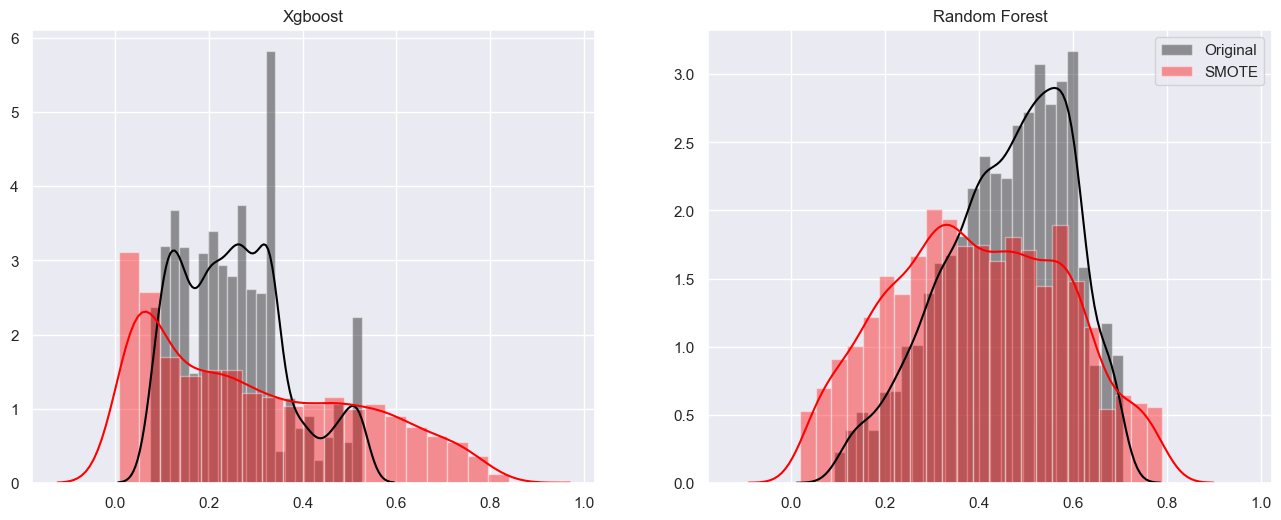

In [91]:
fig, axes = plt.subplots(1,2,figsize=(16,6), dpi= 100, sharex = True)

sns.distplot(yhat_xgb, ax = axes[0], color = 'black', label = 'Original')
sns.distplot(yhat_xgb_smt, ax = axes[0], color = 'red', label = 'SMOTE')
axes[0].set_title('Xgboost')


sns.distplot(yhat_rf, ax = axes[1], color = 'black', label = 'Original')
sns.distplot(yhat_rf_smt, ax = axes[1], color = 'red', label = 'SMOTE')
axes[1].set_title('Random Forest')

plt.legend()
plt.show()

Os gráficos acima mostram que os resultados dos modelos são muito diferentes entre si. A distribuição de probabilidades estimadas no Xgboost é muito mais concentrada próxima a zero. Em contrapartida, no Random Forest as probabilidades estimadas se aproximam de uma distribuição normal centrada em 0,5.

Além disso, é visível o efeito do SMOTE nos modelos, fazendo com que, nos dois algoritmos testados, a média das probabilidades estimadas esteja mais próxima de 0 no Random Forest e de 1 no Xgboost.


Vamos então quantificar os erros do modelo.

## Métricas de Machine Learning

A variável resposta possua duas classes: ser aceito para a análise de crédito (1) ou não (0). Para a Creditas, o que deve ser mais relevante: acertar mais nos casos 1 ou nos casos 0? Vejamos as implicações:  
* Aprovar, inapropriadamente, maus clientes, que deveriam ser reprovados, representa um risco financeiro muito grande, pois eles podem dar default e não pagar as parcelas dos empréstimos, resultado em prejuízo para a empresa. Estes são os falsos positivos, isto é, clientes marcados como 1 que deveriam ter sido marcados como 0.
* Reprovar, de forma errônea, bons clientes, que deveriam ser aprovados, representa um risco financeiro moderado, pois eles seriam bons pagadores que, com o pagamento adimplente dos juros do empréstimo, trariam receita recorrente para a empresa. Esses casos são os falsos negativos.

Assim, pode-se concluir que o erro 1, os falsos positivos, são mais graves e devem ser quantificados e analisados com maior atenção que os falsos negativos. As métricas de Machine Learning que melhor quantificam esse contexto são:  

* False positive rate (FPR), taxa de negativos classificados como positivos dentre todos os casos negativos (`fpr = fp/(fp + tn)`). Quanto menor, melhor.
* False negative rate (FNR), taxa de positivos classificados como negativos dentre todos os casos positivos (`fnr = fn/(fn + tp)`). Quanto menor, melhor. 
* AUC, área sob a curva;

Como métricas de Machine Learning, são calculadas as recomendadas pela literatura, como AUC, True Positive Rate (TPR), Precision, Accuracy e F1 Score.

No contexto deste dataset, TPR representa o porcentual de acertos do modelo dentro do universo dos clientes aceitos  ess

In [92]:
def extrair_metricas_classificacao(yhat_prob, yreal, threshold = 0.5):
    # converter probabilidades estimadas para binárias
    yhat_binario = np.where(yhat_prob >= threshold, 1, 0)
    
    # metricas a extrair: AUC, Recall, Acuracia, F1, D10, ks_max

    try:
        auc = metrics.roc_auc_score(y_true = yreal, y_score = yhat_prob)
    except ValueError:
        auc = np.NaN
    
    # calcular fpr
    fp = np.sum(np.where((yhat_binario == 1) & (yreal == 0), 1, 0))
    fn = np.sum(np.where((yhat_binario == 0) & (yreal == 1), 1, 0))
    tn = np.sum(np.where((yhat_binario == 0) & (yreal == 0), 1, 0))
    tp = np.sum(np.where((yhat_binario == 1) & (yreal == 1), 1, 0))
    
    fpr = fp/(fp + tn)
    fnr = fn/(fn+tp)
    
    # retornar resultados
    dict_out = {
        'AUC': auc,
        'FPR': fpr,
        'FNR': fnr
           }
    # arredondar valores
    for k, v in dict_out.items():
        dict_out[k] = np.round(v, 4)
    
    
    return(dict_out)

In [93]:
# resultados randomforest
extrair_metricas_classificacao(yhat_rf, y_test)

{'AUC': 0.7936, 'FPR': 0.3437, 'FNR': 0.235}

In [94]:
# resultados randomforest
extrair_metricas_classificacao(yhat_rf_smt, y_test)

{'AUC': 0.7908, 'FPR': 0.2299, 'FNR': 0.3703}

In [95]:
# resultados randomforest
extrair_metricas_classificacao(yhat_xgb, y_test)

{'AUC': 0.796, 'FPR': 0.0207, 'FNR': 0.8535}

In [96]:
# resultados randomforest
extrair_metricas_classificacao(yhat_xgb_smt, y_test)

{'AUC': 0.8127, 'FPR': 0.142, 'FNR': 0.4822}

Os resultados de AUC dos 4 testes são muito similares. Em termos de FPR, o Xgboost performa melhor, mas isso é porque ele raramente classifica um caso como positivo. Levando, então, o FNR como critério, percebe-se que o Random Forest com SMOTE é mais equilibrado. Contudo, é válido ressaltar que a escolha do modelo depende muito da métrica escolhida e, portanto, deve ser feita uma discussão maior sobre qual é a mais importante no contexto.

## Métricas de risco de crédito

Além das métricas usadas em problemas de classificação de Machine Learning descritas acima, outras métricas importantes a serem analisadas são as específicas de crédito.

De acordo com o paper [How to Measure the Quality of Credit Scoring Models](https://www.researchgate.net/publication/227436342_How_to_Measure_the_Quality_of_Credit_Scoring_Models), uma das métricas mais usadas é a Estatística de Kolmogorov-Smirnov (KS), que é baseado em medir a máxima separação entre a freqüência relativa acumulada de maus clientes e a freqüência relativa acumulada de bons clientes. No contexto deste trabalho, bons clientes são os enviados para a análise.

O código abaixo implementa o cálculo do KS para as probabilidades estimadas pelos modelos. Alguns comentários sobre os procedimentos:

* As probabilidades estimadas no set de teste são classificadas em decis, isto é, 10 grupos de tamanhos iguais, cujos limites foram estabelecidos a partir das probabilidades estimadas no conjunto de treino. Isso é feito para garantir a estabilidade dos decis para novos datasets.  
* Não é garantido que o set de teste possua um número parecido de clientes por decil, visto que a distribuição das probabilidades pode ser diferente (especialmente nos casos onde houve rebalancing com SMOTE).  
* De acordo com [esta referência](https://www.amazon.com.br/Credit-Scoring-Desenvolvimento-Implanta%C3%A7%C3%A3o-Acompanhamento/dp/8521205333), um KS de 0,40 já pode ser considerado um resultado muito bom.  
* Os resultados do KS são avaliados tanto para o set de treino como para o de teste para analisar a possibilidade de overfitting.



In [109]:
def calcular_decis(model_fit, X_tr, X_te = None):
    # obter probabilidades para o set de treino
    
    if X_te is None:
        X_te = X_tr
    
    y_hat_treino = model_fit.predict_proba(X_tr)[:, 1]
    # acrescentar um elemento 0 e um elemento 1 no vetor de probabilidades para garantir que 
    # os decis compreendam todo o intervalo de probabilidades
    y_hat_treino[np.argmin(y_hat_treino)] = 0
    y_hat_treino[np.argmax(y_hat_treino)] = 1
    
    labels_decis = pd.Series(np.arange(1, 11)).astype(str).str.zfill(2)
    decis_treino, bins_treino = pd.qcut(y_hat_treino, q = 10, retbins = True, labels = labels_decis)
    
    # aplicar bins na previsao do set de teste
    y_hat_teste = model_fit.predict_proba(X_te)[:, 1]
    decis = pd.cut(y_hat_teste, bins = bins_treino, labels = labels_decis)
    
    return(decis)


def ks_decil(vetor_decil, y_true_bin, nome_modelo, nome_dataset):
    tt_bons_geral = np.sum(y_true_bin == 1)
    tt_maus_geral = len(y_true_bin) - tt_bons_geral
    
    d = pd.DataFrame({'decil': vetor_decil,
                     'y': y_true_bin})
    
    d = d.groupby('decil').agg({'y': ['count', 'sum']}).reset_index()
    d.columns = ['decil', 'qtd_clientes', 'qtd_bons']
    d['qtd_maus'] = d.qtd_clientes - d.qtd_bons
    # converter para inteiro
    d['qtd_clientes'] = d['qtd_clientes'].astype(int)
    d['qtd_bons'] = d['qtd_bons'].astype(int)
    d['qtd_maus'] = d['qtd_maus'].astype(int)
    
    # obter ratio
    d['pct_clientes'] = d.qtd_clientes/np.sum(d.qtd_clientes)
    d['pct_clientes_acum'] = np.cumsum(d.pct_clientes)
    d['pct_bons'] = d.qtd_bons/tt_bons_geral
    d['pct_maus'] = d.qtd_maus/tt_maus_geral
    
    d['pct_bons_cum'] = np.cumsum(d.pct_bons)
    d['pct_maus_cum'] = np.cumsum(d.pct_maus)
    # transformar para acumulado
    d['ks_bin'] = np.round(d.pct_maus_cum, 3) - np.round(d.pct_bons_cum, 3)
    # criar coluna para identificar o modelo
    d['modelo'] = nome_modelo
    d['dataset'] = nome_dataset
    ks_max = np.max(d['ks_bin'])
    ks_max = np.round(ks_max, 3)
    
    print('KS ', nome_dataset,  ': ', ks_max)
    
    return(d)

def calcular_ks_modelo_treino_teste(fit, X_train, X_test, y_train, y_test, nome_modelo):
    yhat, decis_treino = calcular_decis(fit, X_train, X_train)
    yhat, decis_test = calcular_decis(fit, X_train, X_test)
    
    ks_tr = ks_decil(vetor_decil = decis_treino, y_true_bin = y_train, nome_modelo = nome_modelo, nome_dataset = 'train')
    ks_te = ks_decil(vetor_decil = decis_test, y_true_bin = y_test, nome_modelo = nome_modelo, nome_dataset = 'test')
    
    # exportar output
    return(yhat, ks_tr, ks_te)


def plot_ks(df_ks_train, df_ks_test):
    df_ks_plot = pd.concat([df_ks_train, df_ks_test], axis = 'rows') 
    df_ks_plot = df_ks_plot[['pct_bons_cum', 'pct_maus_cum', 'decil', 'dataset']]
    df_ks_plot = df_ks_plot.melt(id_vars = ['decil', 'dataset'], var_name = 'curva', value_name = 'valor_acum')
    
    # calcular posições da reta ks
    maior_ks_valor = np.max(df_ks_train['ks_bin'])
    maior_ks_decil = df_ks_train['decil'][np.argmax(df_ks_train['ks_bin'])]
    lim_sup = df_ks_train['pct_maus_cum'][np.argmax(df_ks_train['ks_bin'])]
    lim_inf = df_ks_train['pct_bons_cum'][np.argmax(df_ks_train['ks_bin'])]
    
    sns.lineplot(data = df_ks_plot, x = 'decil', y = 'valor_acum', hue = 'curva', style = 'dataset', markers = True)
    plt.axvline(x = maior_ks_decil, ymin = lim_inf, ymax = lim_sup, color = 'black', linestyle = 'dashed')



Partimos então para calcular o KS para as 4 iterações:

In [110]:
## random forest sem smote

decis_rf_treino = calcular_decis(fit_rf, X_train)
decis_rf_test = calcular_decis(fit_rf, X_train, X_test)


ks_rf_tr = ks_decil(vetor_decil = decis_rf_treino, y_true_bin = y_train, nome_modelo = 'Random Forest', nome_dataset = 'train')
ks_rf_te = ks_decil(vetor_decil = decis_rf_test, y_true_bin = y_test, nome_modelo = 'Random Forest', nome_dataset = 'test')


KS  train :  0.437
KS  test :  0.419


In [111]:
## random forest com smote
decis_rf_treino = calcular_decis(fit_rf_smt, X_train_smt, X_train_smt)
decis_rf_test = calcular_decis(fit_rf_smt, X_train_smt, X_test)

ks_rf_tr_smt = ks_decil(vetor_decil = decis_rf_treino, y_true_bin = y_train_smt, nome_modelo = 'Random Forest', nome_dataset = 'train')
ks_rf_te_smt = ks_decil(vetor_decil = decis_rf_test, y_true_bin = y_test, nome_modelo = 'Random Forest', nome_dataset = 'test')


KS  train :  0.63
KS  test :  0.424


In [112]:
# xgboost sem smote
decis_xgb_treino = calcular_decis(fit_xgb, X_train, X_train)
decis_xgb_test = calcular_decis(fit_xgb, X_train, X_test)

ks_xgb_tr = ks_decil(vetor_decil = decis_xgb_treino, y_true_bin = y_train, nome_modelo = 'Xgboost', nome_dataset = 'train')
ks_xgb_te = ks_decil(vetor_decil = decis_xgb_test, y_true_bin = y_test, nome_modelo = 'Xgboost', nome_dataset = 'test')


KS  train :  0.427
KS  test :  0.425


In [113]:
# xgboost com smote
decis_xgb_treino = calcular_decis(fit_xgb_smt, X_train_smt, X_train_smt)
decis_xgb_test = calcular_decis(fit_xgb_smt, X_train_smt, X_test)


ks_xgb_tr_stm = ks_decil(vetor_decil = decis_xgb_treino, y_true_bin = y_train_smt, nome_modelo = 'Xgboost', nome_dataset = 'train')
ks_xgb_te_stm = ks_decil(vetor_decil = decis_xgb_test, y_true_bin = y_test, nome_modelo = 'Xgboost', nome_dataset = 'test')


KS  train :  0.73
KS  test :  0.465


O melhor KS obtido no set de teste é o do Xgboost com SMOTE, de 0,465. Contudo, há uma diferença muito grande em relação ao dataset de treino. Analisando os resultados dos modelos com e sem SMOTE, percebe-se que essa técnica de oversampling torna difícil a comparação dos sets de treino com o de teste, pois o set de treino sofre uma grande distorção.

In [102]:
ks_xgb_te_stm

,decil,qtd_clientes,qtd_bons,qtd_maus,pct_clientes,pct_clientes_acum,pct_bons,pct_maus,pct_bons_cum,pct_maus_cum,ks_bin,modelo,dataset
0,01,723,7,716,0.16200,0.16200,0.00712,0.20575,0.00712,0.20575,0.19900,Xgboost,test
1,02,682,13,669,0.15281,0.31481,0.01322,0.19224,0.02035,0.39799,0.37800,Xgboost,test
2,03,687,105,582,0.15393,0.46874,0.10682,0.16724,0.12716,0.56523,0.43800,Xgboost,test
3,04,714,136,578,0.15998,0.62873,0.13835,0.16609,0.26551,0.73132,0.46500,Xgboost,test
4,05,656,214,442,0.14699,0.77571,0.21770,0.12701,0.48321,0.85833,0.37500,Xgboost,test
5,06,547,231,316,0.12256,0.89827,0.23499,0.09080,0.71821,0.94914,0.23100,Xgboost,test
6,07,367,212,155,0.08223,0.98051,0.21567,0.04454,0.93388,0.99368,0.06000,Xgboost,test
7,08,87,65,22,0.01949,1.00000,0.06612,0.00632,1.00000,1.00000,0.00000,Xgboost,test
8,09,0,0,0,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,Xgboost,test
9,10,0,0,0,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,Xgboost,test


Vemos na tabela que os resultados são interessantes. Como foi explicado, os decis não possuem o mesmo tamanho no dataset, sendo que o primeiro representa 16,2% do dataset de teste, por exemplo.

O decil 04 é onde ocorrre a maior separação entre as classes de clientes bons e maus, sendo, portanto, 0,73 o KS do modelo no set de teste. Vejamos esse resultado por forma de um gráfico: 


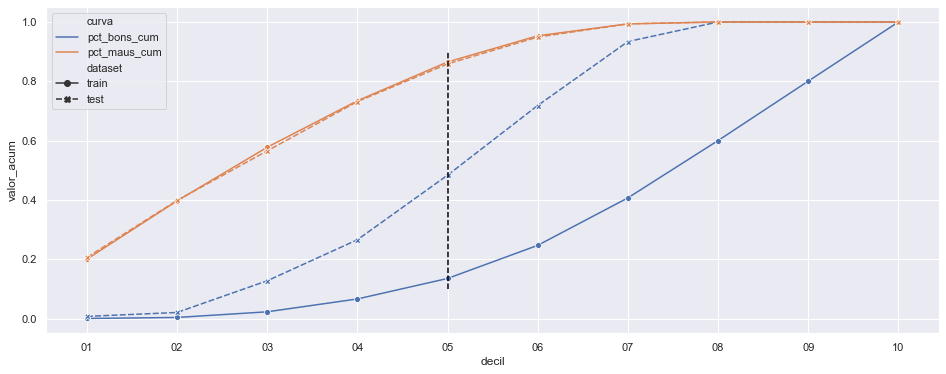

In [114]:

plt.figure(figsize=(16, 6))
plot_ks(ks_xgb_tr_stm, ks_xgb_te_stm)
plt.show()

# Interpretabilidade

Finalmente, deseja-se entender a importância de cada variável explicativa. A tabela abaixo mostra os resultados de feature importante para o modelo de Random Forest:

In [117]:
best_model = fit_xgb_smt.best_estimator_

df_var_imp = pd.DataFrame(best_model.feature_importances_, index = X_train.columns, columns = ['importance']).sort_values('importance', ascending = False)

df_var_imp['ranking'] = df_var_imp['importance'].rank(ascending = False).astype(int)

df_var_imp.head(20)

,importance,ranking
form_completed,0.10780,1
education_level_G-Ensino medio completo,0.06880,2
landing_page_product_missing,0.06556,3
education_level_H-Ensino superior incompleto,0.05694,4
education_level_I-Ensino superior completo,0.05236,5
landing_page_product_PersonalLoan,0.05174,6
informed_restriction,0.04688,7
taxa_valor_carro_sobre_emprestimo_B,0.04406,8
verified_restriction,0.04085,9
education_level_outros,0.03894,10


Algo interessante a ser destacado é que algumas variáveis criadas ou modficiadas no processo de feature engineering, como `taxa_valor_carro_sobre_emprestimo`, aparecem dentre as 8 mais importantes para o modelo.

# Conclusão e to-dos

O processo de tratamento de dados ausentes e de feature engineering foi bem sucedido. O modelo apresentado obteve bons resultados de acordo com a literatura de credit scoring.

Como próximos passos de uma extensão mais longa desse trabalho, sugeriria:  

* A partir dos dados de zip code descriptografados, construir variáveis socioeconômicas do setor censitário de onde o cliente mora. Provavelmente será uma variável ainda melhor que as de nível municipal.  
* Configurar o campo de cidade para ser construído a partir do CEP informado pelo cliente, para eliminar os problemas de data entry.  
* Claro, sempre é possível testar outros modelos além dos analisados neste trabalho, como Redes Neurais e SVM.